# Loading the dataset

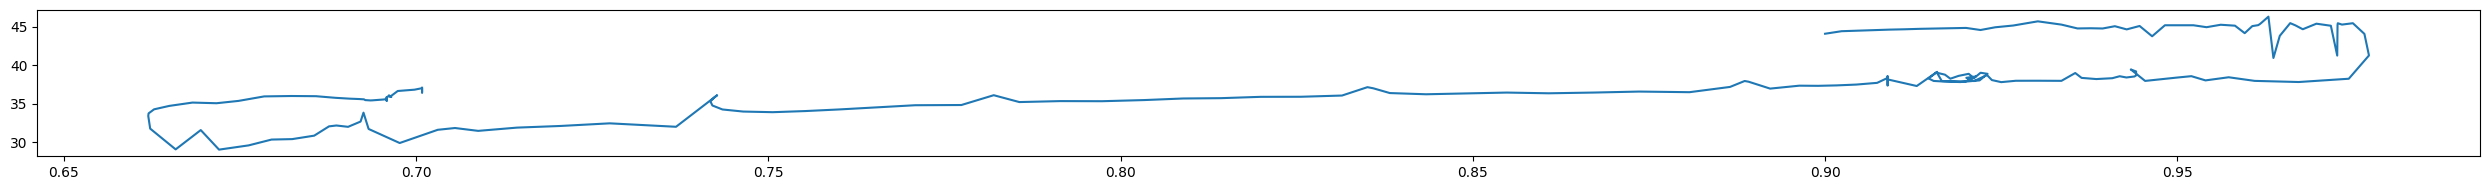

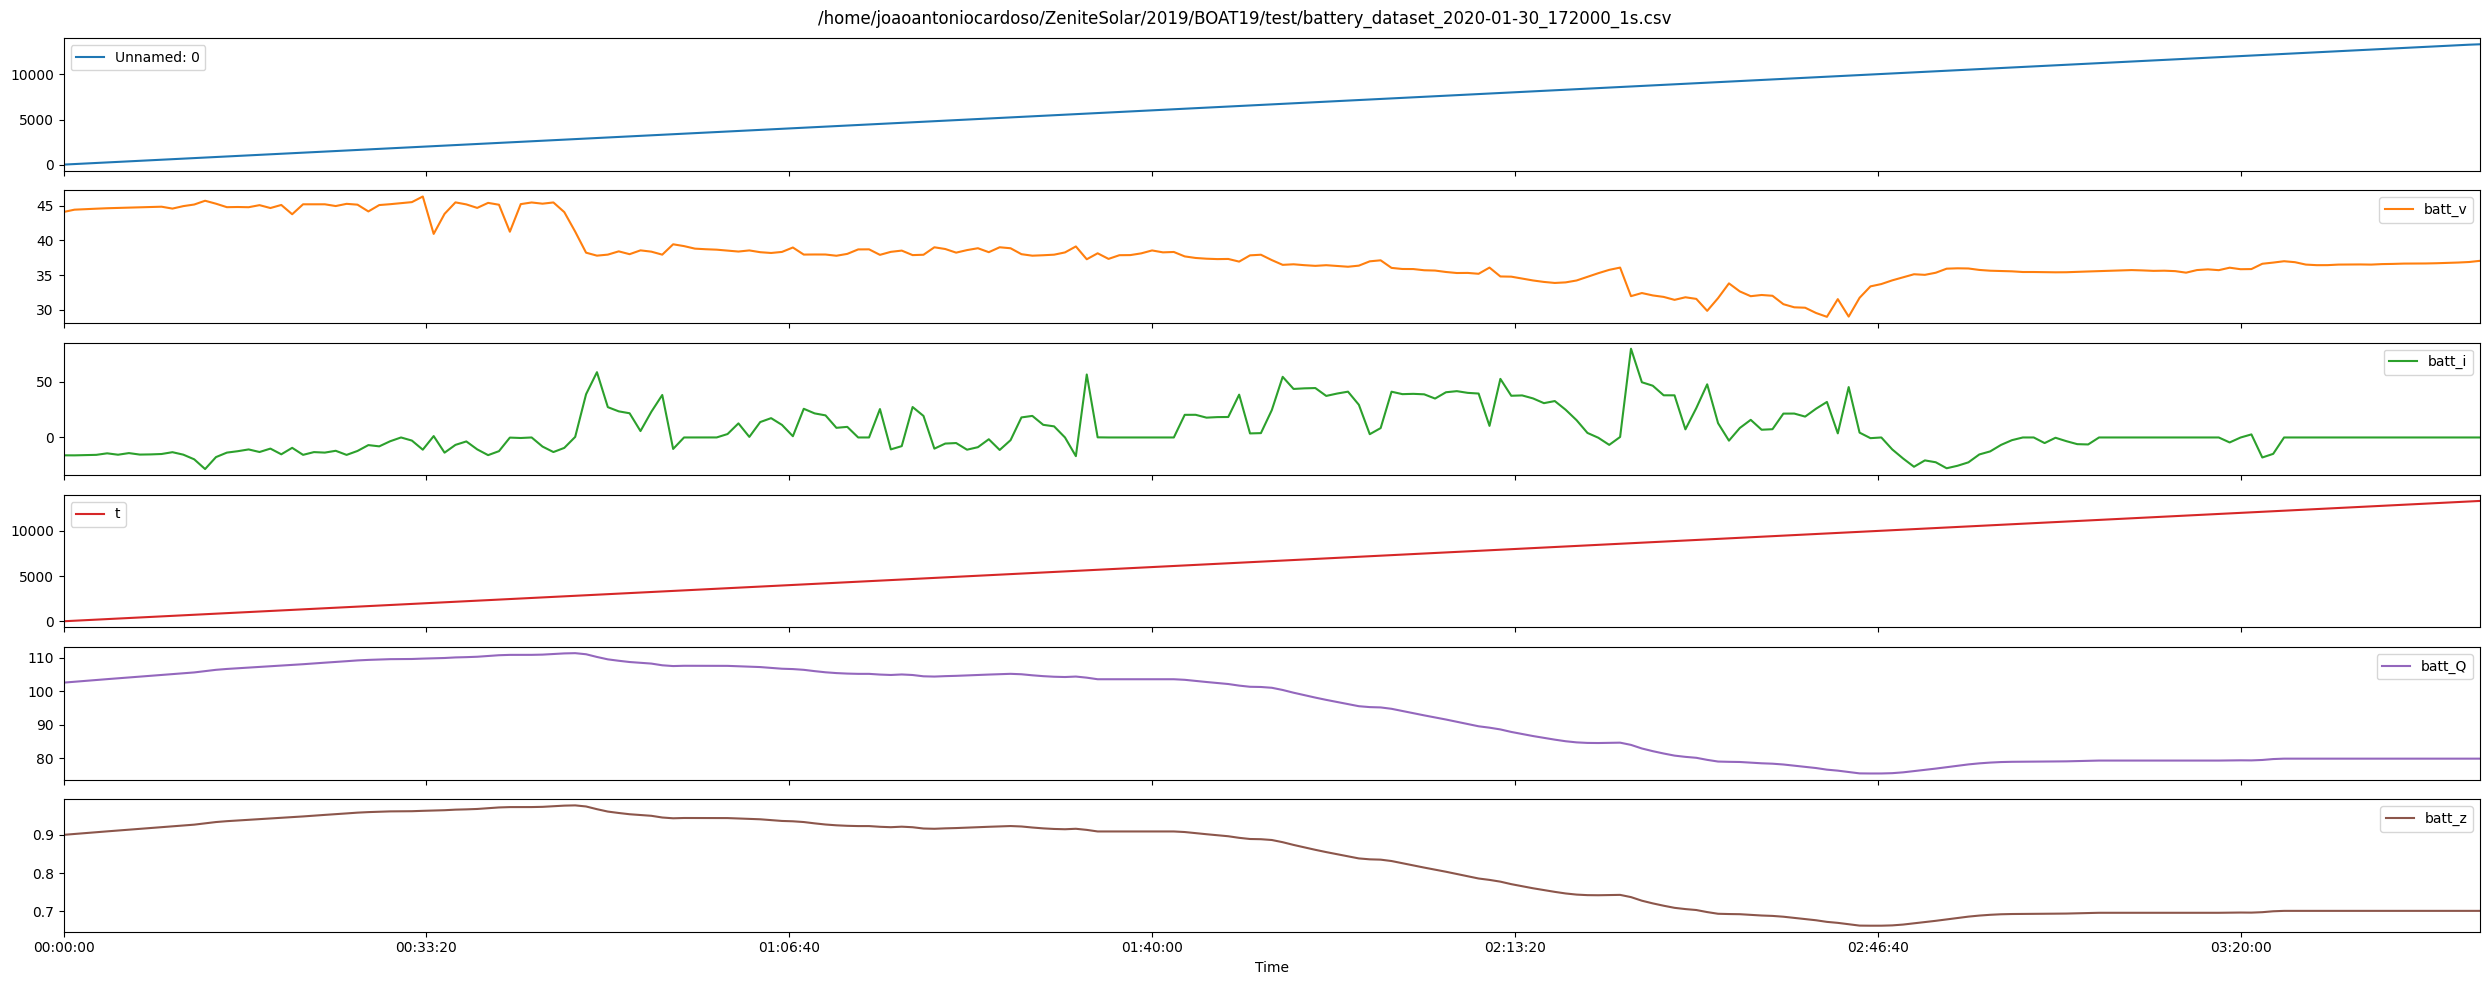

,Unnamed: 0,batt_v,batt_i,t,batt_Q,batt_z
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,6689.434978,37.958480,6.072541,6660.000000,94.539787,0.829296
std,3871.011618,4.095043,19.780656,3871.123868,12.923608,0.113365
min,29.500000,29.015624,-28.269492,0.000000,75.466365,0.661986
25%,3359.500000,35.626697,-7.853833,3330.000000,79.897238,0.700853
50%,6689.500000,37.136850,0.000000,6660.000000,101.062123,0.886510
75%,10019.500000,38.841962,18.500711,9990.000000,106.037181,0.930151
max,13335.000000,46.306309,79.444659,13320.000000,111.400947,0.977201


,Unnamed: 0,batt_v,batt_i,t,batt_Q,batt_z
Time,,,,,,
0 days 00:00:00,29.5,44.084269,-15.978034,0.0,102.600000,0.900000
0 days 00:01:00,89.5,44.413586,-16.012333,60.0,102.866586,0.902338
0 days 00:02:00,149.5,44.488303,-15.828339,120.0,103.131925,0.904666
0 days 00:03:00,209.5,44.554942,-15.564214,180.0,103.393530,0.906961
0 days 00:04:00,269.5,44.619557,-14.194605,240.0,103.641520,0.909136
...,...,...,...,...,...,...
0 days 03:38:00,13109.5,36.716509,0.000000,13080.0,79.897238,0.700853
0 days 03:39:00,13169.5,36.769049,0.000000,13140.0,79.897238,0.700853
0 days 03:40:00,13229.5,36.817804,0.000000,13200.0,79.897238,0.700853


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def compute_df_z(df, nominal_Q, inplace=False):
    """
    Compute the State of Charge (z) of a battery.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        inplace (bool, optional): If True, the z values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed z values as a fraction of the nominal capacity.

    Notes:
        - The input DataFrame `df` is expected to contain a column named 'batt_Q' representing the battery charge.
        - The output z values are dimensionless fractions representing the battery's charge level relative to its nominal capacity.
        - If `inplace` is True, the computed z values are added as a new column 'batt_z' to the input DataFrame `df`.
    """
    z = df['batt_Q'].to_numpy() / nominal_Q

    if inplace:
        df['batt_z'] = z
    return z

def compute_df_capacity(df, nominal_Q, initial_z, inplace=False):
    """
    Compute the capacity of a battery based on cumulative integration of current over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        initial_z (float): Initial State of Charge (z) as a fraction of the nominal capacity.
        inplace (bool, optional): If True, the computed capacity values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed capacity values in Ampere-hours (Ah).

    Notes:
        - The input DataFrame `df` is expected to contain columns 'batt_i' for battery current and 't' for time.
        - The output capacity values represent the remaining battery capacity after cumulative integration of current over time.
        - The input parameter `initial_z` is a dimensionless fraction representing the initial battery charge relative to its nominal capacity.
        - If `inplace` is True, the computed capacity values are added as a new column 'batt_Q' to the input DataFrame `df`.
    """
    from scipy.integrate import cumulative_trapezoid as cumtrapz

    time_hours = df['t'] / 3600.0  # Converts time in seconds to time in hours
    Q = (nominal_Q * initial_z) - cumtrapz(df['batt_i'], time_hours, initial=0)  # units: Amper-hour

    if inplace:
        df['batt_Q'] = Q
    return Q


def load_df(filename, nominal_Q, initial_z, resample_rule='1s', rename_columns={}):
    df = pd.read_csv(filename)
    df = df.fillna(0.0)
    df = df.rename(columns=rename_columns)
    df = df[df['batt_v'] > 10]

    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df['Time'] = df['Time'] - df['Time'][0]

    df = df.set_index('Time', drop=True)

    # Resampling
    df = (df
        .resample(resample_rule)
        .mean()
        .interpolate(method='time', limit_area='inside')
    )

    # After resampling, create the equally-spaced 't' index, used for control simulations
    df['t'] = df.index.to_numpy(dtype='timedelta64[s]').astype(float)  # t is now a float in seconds

    compute_df_capacity(df, nominal_Q, initial_z, inplace=True)
    compute_df_z(df, nominal_Q, inplace=True)

    return df

filename = '/home/joaoantoniocardoso/ZeniteSolar/2019/BOAT19/test/battery_dataset_2020-01-30_172000_1s.csv'  # Interessante
# filename = '/home/joaoantoniocardoso/ZeniteSolar/2019/BOAT19/test/battery_dataset_2020-02-01_064222_1s.csv'  # Sprint
# filename = '/home/joaoantoniocardoso/ZeniteSolar/2019/BOAT19/test/battery_dataset_2020-02-01_064223_1s.csv'  # After sprint, mostly charging
rename_columns = {'t': 'Time', 'V': 'batt_v', 'I': 'batt_i'}

cell_amps_hour = 38
series_cells = 3
parallel_cells = 1
nominal_Q = series_cells * parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_z = 0.9

df = load_df(filename, resample_rule='1min', rename_columns=rename_columns, nominal_Q=nominal_Q, initial_z=initial_z)

plt.figure(figsize=(25, 2))
plt.plot(df['batt_z'], df['batt_v'])
plt.tight_layout()
plt.show()

df.plot(subplots=True, figsize=(25,10), title=filename)
plt.tight_layout()
plt.show()

display(df.describe())

df

# Battery Equivalent Circuit Model

![](feZkCLr.png)

As seguintes equações representam o sistema da imagem acima, onde $z(t)$ é o estado de carga da bateria:

$$ \begin{aligned}
    \frac{di_{R_{1}}(t)}{dt} &= 
        -\frac{1}{R_{1} C_{1}} i_{R_{1}}(t) 
        +\frac{1}{R_{1} C_{1}} i(t) \\
    v(t) &= 
        -R_{1} i_{R_{1}}(t) 
        -R_{0} i(t) 
        +OCV(z(t)) 
\end{aligned} $$

O estado de carga ($z(t)$) pode ser definido como nas equações abaixo, onde $Q$ é a carga nominal da bateria, e $\eta$, a eficiência culombica:

$$ \begin{aligned}
    z(t) &= 
        z(t_{0}) 
        -\frac{1}{Q} \int_{t_{0}}^t \eta(t) i(t) dt \\
    \frac{dz(t)}{dt} &= 
        -\frac{\eta(t) i(t)}{Q}
\end{aligned} $$

Para que possam ser utilizadas os métodos de solução de sistemas no espaço de estados, podemos separar $VOC(z(t))$ em um modelo externo, considerando-o como uma entrada, deste modo, a função $VOC(z(t))$ pode ser um modelo caixa-preta.

<!-- $$ \begin{aligned}
    VOC(z(t)) &= 
        \sum_{i=0}^{7}\left(c_{i} z^{i}(t)\right) 
        +c_{8} e^{c_{9} z(t)}
\end{aligned} $$ -->

Considerando os estados $X$, entrada $U$ e saídas $Y$:

$$ \begin{aligned}
    X &= 
        \begin{bmatrix}
            i_{R_{1}}(t) \\
            z(t)
        \end{bmatrix} \\
    Y &= 
        \begin{bmatrix}
            v(t) \\
            z(t)
        \end{bmatrix} \\
    U &= 
        \begin{bmatrix}
            i(t) \\
            VOC(z(t))
        \end{bmatrix}
\end{aligned} $$

Considerando a representação no espaço de estados como:

$$ \begin{aligned}
    \dot{X} &= AX + BU \\
    Y &= CX + DU
\end{aligned} $$

As equações do circuito pode ser re-escritas como:

$$ \begin{aligned}
    \dot{X_{0}} &= 
        -\frac{1}{R_{1} C_{1}} X_{0}
        +\frac{1}{R_{1} C_{1}} U_{0} \\
    Y_{0} &= 
        -R_{1} X_{0}
        -R_{0} U_{0}
        +U_{1}
\end{aligned} $$

Enquanto as equações da relação do estado de carga, considerando uma eficiencia culombica $\eta$ constante, ficam:

$$ \begin{aligned}
    \dot{X_{1}} &= 
        -\frac{\eta}{Q} U_{0} \\
    Y_{1} &=
        X_{1}
\end{aligned} $$

Logo, as matrizes do Espaço de Estados são:

$$ \begin{aligned}
    A &= 
        \begin{bmatrix}
            -\frac{1}{R_{1} C_{1}}    & 0 \\
            0                         & 0
        \end{bmatrix} \\
    B &= 
        \begin{bmatrix}
            \frac{1}{R_{1} C_{1}}     & 0 \\
            -\frac{\eta}{Q} U_{0}     & 0
        \end{bmatrix} \\
    C &= 
        \begin{bmatrix}
            -R_{1}    & 0 \\
            0         & 1
        \end{bmatrix} \\
    D &= 
        \begin{bmatrix}
            -R_{0}    & 0 \\
            0         & 0
        \end{bmatrix}
\end{aligned} $$

In [2]:
import sympy as sym

d = sym.Derivative
f = sym.Function
t, s = sym.symbols('t s', constant=False)

# Functions
I = f('I')(t)
V = f('V')(t)
Z = f('Z')(t)
I_R_1 = f('I_R_1')(t)
VOC = f('VOC')(Z)

# Constants
R_0, R_1, C_1, eta, Q = sym.symbols(
    'R_0 R_1 C_1 \eta Q',
    real=True, constant=True, positive=True
)

# Space state dummy functions
X = f('X')(t)  # states
Y = f('Y')(t)  # output
U = f('U')(t)  # inputs

# Space states dummy matrix variables
A, B, C, D = sym.symbols('A B C D')

# Dummy standard space states equations
eq_ss1 = sym.Eq(d(X, t), A * X + B * U, evaluate=False)
eq_ss2 = sym.Eq(Y      , C * X + D * U, evaluate=False)

display(eq_ss1, eq_ss2)
# print(sym.latex(eq_ss1))
# print(sym.latex(eq_ss2))

# States, shape 'nx1' -> '2x1'
X = sym.Matrix([
    [I_R_1],
    [Z]
])

# Inputs, shape 'mx1' -> '2x1'
U = sym.Matrix([
    [I],
    [VOC]
])

# Outputs, shape 'px1' -> '2x1'
Y = sym.Matrix([
    [V],
    [Z]
])

# State Transition matrix, shape 'n,n' -> '2x2'
A = sym.Matrix([
    [-1 / (R_1 * C_1), 0],
    [0,                0]
])

# Input matrix, shape 'n,m' -> '2x2'
B = sym.Matrix([
    [+1 / (R_1 * C_1), 0],
    [-eta / Q,         0]
])

# Output matrix, shape 'p,n' -> '2x2'
C = sym.Matrix([
    [-R_1, 0],
    [0,    1]
])

# Remaining matrix, shape 'p,m' -> '2x2'
D = sym.Matrix([
    [-R_0, 1],
    [0,    0]
])

# Display the equations
eq_ss1 = sym.Eq(d(X, t), A * X + B * U, evaluate=False)
eq_ss2 = sym.Eq(Y      , C * X + D * U, evaluate=False)

display(eq_ss1, eq_ss2)
# print(sym.latex(eq_ss1))
# print(sym.latex(eq_ss2))

Eq(Derivative(X(t), t), A*X(t) + B*U(t))

Eq(Y(t), C*X(t) + D*U(t))

Eq(Derivative(Matrix([
[I_R_1(t)],
[    Z(t)]]), t), Matrix([
[I(t)/(C_1*R_1) - I_R_1(t)/(C_1*R_1)],
[                       -\eta*I(t)/Q]]))

Eq(Matrix([
[V(t)],
[Z(t)]]), Matrix([
[-R_0*I(t) - R_1*I_R_1(t) + VOC(Z(t))],
[                                Z(t)]]))

# Otimização

In [3]:
import control
import lmfit

def func_ocv(soc, coeffs):
    p = np.polynomial.Polynomial(coeffs)
    return p(soc)

def ss_battery(params: dict) -> control.StateSpace:
    params = {
        R_0: params['R_0'],
        R_1: params['R_1'],
        C_1: params['C_1'],
        eta: params['eta'],
        Q: params['Q'],
    }
    return control.ss(
        A.subs(params),
        B.subs(params),
        C.subs(params),
        D.subs(params)
    )

def simulate_battery(ss, df_in) -> pd.DataFrame:
    df_out = pd.DataFrame().reindex_like(df_in)
    t = df_in['t']
    U = np.array([
        df_in['batt_i'],
        df_in['batt_ocv']
    ])
    X0 = np.array([
        [df_in['batt_i'].head(1).item()],
        [df_in['batt_z'].head(1).item()],
    ])

    _, yout, _xout = control.forced_response(
        ss, T=t, U=U, X0=X0, return_x=True, squeeze=True)

    df_out['batt_v'] = yout[0]
    df_out['batt_z'] = yout[1]
    df_out['batt_i'] = U[0]
    df_out['batt_ocv'] = U[1]

    return df_out

def func(dfi,
         R_0, R_1, C_1, eta, Q,
         c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10):

    dfi['batt_ocv'] = func_ocv(
        soc=dfi['batt_z'],
        coeffs=[c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10]
    )

    params = {
        'R_0': R_0,
        'R_1': R_1,
        'C_1': C_1,
        'eta': eta,
        'Q': Q,
    }
    ss = ss_battery(params)

    dfi = simulate_battery(ss, dfi)

    data = np.array([dfi['batt_v'], dfi['batt_i'], dfi['batt_z']])
    return data

def model_fit(model, params, method, dfi):
    data = np.array([dfi['batt_v'], dfi['batt_i'], dfi['batt_z']])
    return model.fit(
        data=data,
        params=params,
        method=method,
        dfi=dfi,
    )

def model_eval(model_or_result, dfi):
    data = model_or_result.eval(dfi=dfi)
    dfi = pd.DataFrame()
    dfi['batt_v'] = data[0]
    dfi['batt_i'] = data[1]
    dfi['batt_z'] = data[2]
    return dfi

def model_eval_and_plot(model_or_result, dfi):
    df_pred = model_eval(model_or_result, dfi=dfi)

    plt.figure(figsize=(25,2))
    plt.plot(dfi.index, df_pred['batt_v'], label='Model: Best Fit')
    plt.plot(dfi.index, dfi['batt_v'], label='Data')
    plt.title('Voltage vs Time')
    plt.xlabel('t [s]')
    plt.ylabel('V [V]')
    plt.legend()
    plt.show()

    plt.figure(figsize=(25,2))
    plt.plot(dfi.index, df_pred['batt_z'], label='Model: Best Fit')
    plt.plot(dfi.index, dfi['batt_z'], label='Data')
    plt.title('SOC vs Time')
    plt.xlabel('t [s]')
    plt.ylabel('SOC [%]')
    plt.legend()
    plt.show()

    plt.figure(figsize=(25,2))
    plt.plot(df_pred['batt_z'], df_pred['batt_v'], label='Model: Best Fit')
    plt.plot(dfi['batt_z'], dfi['batt_v'], label='Data')
    plt.title('Voltage vs SOC')
    plt.xlabel('SOC [%]')
    plt.ylabel('V [V]')
    plt.legend()
    plt.show()

    plt.figure(figsize=(25,2))
    plt.plot(df_pred['batt_z'], df_pred['batt_i'], label='Model: Best Fit')
    plt.plot(dfi['batt_z'], dfi['batt_i'], label='Data')
    plt.title('Current vs SOC')
    plt.xlabel('SOC [%]')
    plt.ylabel('I [I]')
    plt.legend()
    plt.show()

model = lmfit.Model(
    func=func,
    independent_vars=['dfi'],
    param_names=[R_0, R_1, C_1, 'eta', Q,
                 'c0', 'c1', 'c2', 'c3',
                 'c4', 'c5', 'c6', 'c7',
                 'c8', 'c9', 'c10'],
)

Executando a otimização dos parâmetros do modelo:

In [4]:
params = lmfit.Parameters()
params.add_many(
    # NAME, VALUE, VARY, MIN,  MAX,  EXPR, BRUTE_STEP
    ('R_0', 0, True, 1e-6, 1, None, None),
    ('R_1', 0, True, 1e-6, 1, None, None),
    ('C_1', 0, True, 1, 1e9, None, None),
    ('eta', 0.5, True, -2, 2, None, None),
    ('Q', df['batt_Q'].head(1).item() * 3600, False, 1, 1e9, None, None),  # units: amper-seconds
    ('c0', 0, False, -1e6, 1e6, None, None),
    ('c1', 0, True, -1e6, 1e6, None, None),
    ('c2', 0, True, -1e6, 1e6, None, None),
    ('c3', 0, True, -1e6, 1e6, None, None),
    ('c4', 0, False, -1e6, 1e6, None, None),
    ('c5', 0, False, -1e6, 1e6, None, None),
    ('c6', 0, False, -1e6, 1e6, None, None),
    ('c7', 0, False, -1e6, 1e6, None, None),
    ('c8', 0, False, -1e6, 1e6, None, None),
    ('c9', 0, False, -1e6, 1e6, None, None),
    ('c10', 0, False, -1e6, 1e6, None, None),
)

# https://lmfit.github.io/lmfit-py/fitting.html#choosing-different-fitting-methods
# local methods:
method = 'least_squares'    # ok, 2m42s
# global methods:
# method = 'differential_evolution'  # ok, 45m
result = model_fit(model, params, method, df)

df_hf = load_df(filename, resample_rule='1s', rename_columns=rename_columns, nominal_C=nominal_C, initial_SOC=initial_SOC)
model_eval_and_plot(result, df_hf)

result

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices